In [1]:
!pip install kaggle

In [0]:
!mkdir .kaggle

In [4]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge

  0% 0.00/501k [00:00<?, ?B/s]
100% 501k/501k [00:00<00:00, 73.9MB/s]
100% 1.04G/1.04G [00:06<00:00, 196MB/s]
100% 1.04G/1.04G [00:06<00:00, 175MB/s]
100% 2.45G/2.46G [00:17<00:00, 160MB/s]
100% 2.46G/2.46G [00:17<00:00, 148MB/s]
  0% 0.00/50.0 [00:00<?, ?B/s]
100% 50.0/50.0 [00:00<00:00, 48.4kB/s]


In [7]:
!7z x /content/{/content}/competitions/tensorflow-speech-recognition-challenge/train.7z -o./train


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/{/content}/competitions . ow-speech-recognition-challenge/                                                                             1 file, 1121103842 bytes (1070 MiB)

Extracting archive: /content/{/content}/competitions/tensorflow-speech-recognition-challenge/train.7z
--
Path = /content/{/content}/competitions/tensorflow-speech-recognition-challenge/train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav

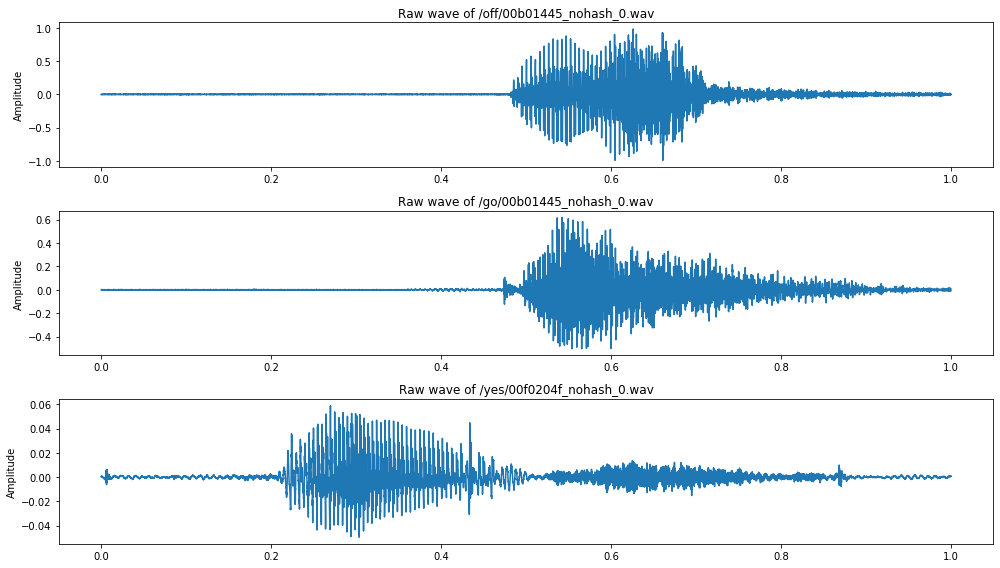

In [10]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
 
DIR = 'train/train/audio'
fns = ['/off/00b01445_nohash_0.wav',
       '/go/00b01445_nohash_0.wav',
       '/yes/00f0204f_nohash_0.wav']
SAMPLE_RATE = 16000
 
def read_wav_file(x):
    # Read wavfile using scipy wavfile.read
    _, wav = wavfile.read(x) 
    # Normalize
    wav = wav.astype(np.float32) / np.iinfo(np.int16).max
        
    return wav
 
fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)
 
    ax = fig.add_subplot(3,1,i+1)
    ax.set_title('Raw wave of ' + fn)
    ax.set_ylabel('Amplitude')
    ax.plot(np.linspace(0, SAMPLE_RATE/len(wav), SAMPLE_RATE), wav)
fig.tight_layout()

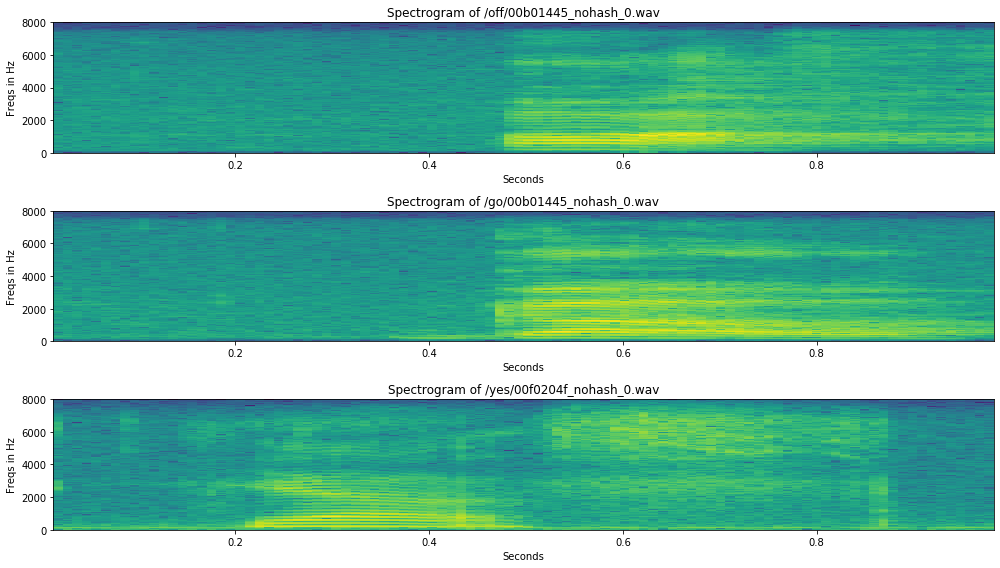

In [11]:
from scipy.signal import stft

def log_spectrogram(wav):
    freqs, times, spec = stft(wav, SAMPLE_RATE, nperseg = 400, noverlap = 240, nfft = 512, 
                              padded = False, boundary = None)
    # Log spectrogram
    amp = np.log(np.abs(spec)+1e-10)
    
    return freqs, times, amp

fig = plt.figure(figsize=(14, 8))
for i, fn in enumerate(fns):
    wav = read_wav_file(DIR + fn)
    freqs, times, amp = log_spectrogram(wav)
    
    ax = fig.add_subplot(3,1,i+1)
    ax.imshow(amp, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax.set_title('Spectrogram of ' + fn)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')
fig.tight_layout()

In [0]:
wav_files = glob(os.path.join(DIR, '*/*wav'))

In [34]:
x 

'train/train/audio/bed/ee07dcb9_nohash_0.wav'

In [44]:
wav_files = [x.split(sep='/')[3] + '/' + x.split(sep='/')[4] for x in wav_files]
x.split(sep='/')[3] + '/' + x.split(sep='/')[4]

'bed/ee07dcb9_nohash_0.wav'

In [43]:
x.split(sep='/')[3]

'bed'

In [0]:
import os
import numpy as np
import pandas as pd
import random
    
from glob import glob

from scipy.io import wavfile
from scipy.signal import stft

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical

class DatasetGenerator():
    def __init__(self, label_set, 
                 sample_rate=16000):
        
        self.label_set = label_set
        self.sample_rate = sample_rate
            
    # Covert string to numerical classes              
    def text_to_labels(self, text):
        return self.label_set.index(text)
    
    # Reverse translation of numerical classes back to characters
    def labels_to_text(self, labels):
        return self.label_set[labels]               
        
    def load_data(self, DIR):

        # Get all paths inside DIR that ends with wav
        wav_files = glob(os.path.join(DIR, '*/*wav'))
        wav_files = [x.split(sep='/')[3] + '/' + x.split(sep='/')[4] for x in wav_files]
       
        # Loop over files to get samples
        data = []
        for e in wav_files:
            
            label, name = e.split('/')
            if label in self.label_set:
                label_id = self.text_to_labels(label)
                fle = os.path.join(DIR, e)
                
                sample = (label, label_id, name, fle)
                data.append(sample)
            
        # Data Frames with samples' labels and paths     
        df = pd.DataFrame(data, columns = ['label', 'label_id', 'user_id', 'wav_file'])
        
        self.df = df
        
        return self.df

    def apply_train_test_split(self, test_size, random_state):
        
        self.df_train, self.df_test = train_test_split(self.df, 
                                                       test_size=test_size,
                                                       random_state=random_state)
        
    def apply_train_val_split(self, val_size, random_state):
        
        self.df_train, self.df_val = train_test_split(self.df_train, 
                                                      test_size=val_size, 
                                                      random_state=random_state)
        
    def read_wav_file(self, x):
        # Read wavfile using scipy wavfile.read
        _, wav = wavfile.read(x) 
        # Normalize
        wav = wav.astype(np.float32) / np.iinfo(np.int16).max
            
        return wav
    
    def process_wav_file(self, x, threshold_freq=5500, eps=1e-10):
        # Read wav file to array
        wav = self.read_wav_file(x)
        # Sample rate
        L = self.sample_rate
        # If longer then randomly truncate
        if len(wav) > L:
            i = np.random.randint(0, len(wav) - L)
            wav = wav[i:(i+L)]  
        # If shorter then randomly add silence
        elif len(wav) < L:
            rem_len = L - len(wav)
            silence_part = np.random.randint(-100,100,16000).astype(np.float32) / np.iinfo(np.int16).max
            j = np.random.randint(0, rem_len)
            silence_part_left  = silence_part[0:j]
            silence_part_right = silence_part[j:rem_len]
            wav = np.concatenate([silence_part_left, wav, silence_part_right])
        # Create spectrogram using discrete FFT (change basis to frequencies)
        freqs, times, spec = stft(wav, L, nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None)
        # Cut high frequencies
        if threshold_freq is not None:
            spec = spec[freqs <= threshold_freq,:]
            freqs = freqs[freqs <= threshold_freq]
        # Log spectrogram
        amp = np.log(np.abs(spec)+eps)
    
        return np.expand_dims(amp, axis=2) 

    def generator(self, batch_size, mode):
        while True:
            # Depending on mode select DataFrame with paths
            if mode == 'train':
                df = self.df_train 
                ids = random.sample(range(df.shape[0]), df.shape[0])
            elif mode == 'val':
                df = self.df_val
                ids = list(range(df.shape[0]))
            elif mode == 'test':
                df = self.df_test
                ids = list(range(df.shape[0]))
            else:
                raise ValueError('The mode should be either train, val or test.')
                
            # Create batches (for training data the batches are randomly permuted)
            for start in range(0, len(ids), batch_size):
                X_batch = []
                if mode != 'test': 
                    y_batch = []
                end = min(start + batch_size, len(ids))
                i_batch = ids[start:end]
                for i in i_batch:
                    X_batch.append(self.process_wav_file(df.wav_file.values[i]))
                    if mode != 'test':
                        y_batch.append(df.label_id.values[i])
                X_batch = np.array(X_batch)

                if mode != 'test':
                    y_batch = to_categorical(y_batch, num_classes = len(self.label_set))
                    yield (X_batch, y_batch)
                else:
                    yield X_batch

In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten

In [0]:
def deep_cnn(features_shape, num_classes, act='relu'):

    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Block 1
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block1_conv', input_shape=features_shape)(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block1_pool')(o)
    o = BatchNormalization(name='block1_norm')(o)
    
    # Block 2
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block2_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block2_pool')(o)
    o = BatchNormalization(name='block2_norm')(o)

    # Block 3
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block3_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block3_pool')(o)
    o = BatchNormalization(name='block3_norm')(o)

    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(64, activation=act, name='dense')(o)
    o = BatchNormalization(name='dense_norm')(o)
    o = Dropout(0.2, name='dropout')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)

    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

In [0]:

import numpy as np
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping

In [0]:

INPUT_SHAPE = (177,98,1)
BATCH = 32
EPOCHS = 15

LABELS = 'yes no up'.split()
NUM_CLASSES = len(LABELS)

In [0]:
DIR = 'train/train/audio'

In [0]:
dsGen = DatasetGenerator(label_set=LABELS) 
# Load DataFrame with paths/labels for training and validation data 
# and paths for testing data 


In [0]:
df = dsGen.load_data(DIR)



In [0]:
dsGen.apply_train_test_split(test_size=0.3, random_state=2018)
dsGen.apply_train_val_split(val_size=0.2, random_state=2018)

In [0]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 


In [51]:
model = deep_cnn(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]

history = model.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 177, 98, 1)        0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 177, 98, 32)       320       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 89, 49, 32)        0         
_________________________________________________________________
block1_norm (BatchNormalizat (None, 89, 49, 32)        128       
_________________________________________________________________
block2_conv (Conv2D)         (None, 89, 49, 32)        9248      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 25, 32)        0         

In [52]:
y_pred_proba = model.predict_generator(dsGen.generator(BATCH, mode='test'), 
                                     int(np.ceil(len(dsGen.df_test)/BATCH)), 
                                     verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

y_true = dsGen.df_test['label_id'].values

67/67 [==============================] - 4s 60ms/step


In [53]:
acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

0.930341280972417
